# Code

## Setup and Imports

In [ ]:
!pip install -q sklearn

In [ ]:
%tensorflow_version 2.x

In [ ]:
from __future__ import absolute_import, unicode_literals, division, print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

## Regression

### Data


In [ ]:
df_train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
df_eval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = df_train.pop('survived')
y_eval = df_eval.pop('survived')

In [ ]:
df_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [ ]:
df_train.shape

(627, 9)

### Data exploration

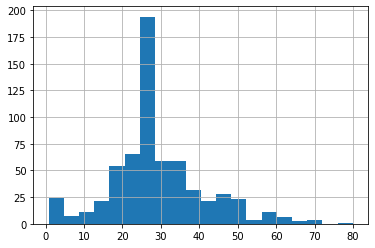

In [ ]:
df_train.age.hist(bins=20)

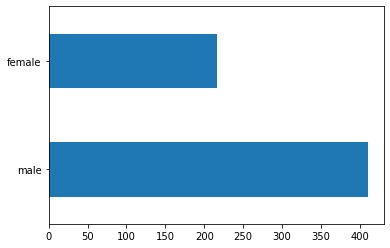

In [ ]:
df_train.sex.value_counts().plot(kind='barh')

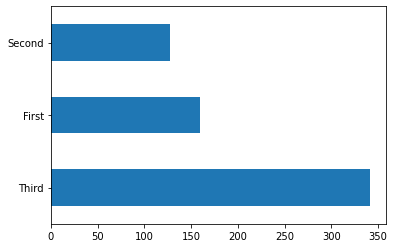

In [ ]:
df_train['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

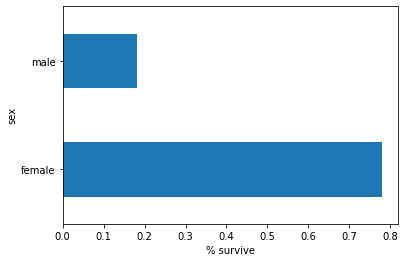

In [ ]:
pd.concat([df_train, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [ ]:
survivors = pd.concat([df_train, y_train], axis=1)
survivors = survivors[survivors['survived'] == 1]
survivors.age.mean()

29.110411522633743

### Feature Columns


In [ ]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = df_train[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

In [ ]:
df_train['embark_town'].unique()

array(['Southampton', 'Cherbourg', 'Queenstown', 'unknown'], dtype=object)

### Creating the Model

#### Input function

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(df_train, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(df_eval, y_eval, num_epochs=1, shuffle=False)

#### Training


In [ ]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmptlah0bej', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model
print(result)

0.7689394
{'accuracy': 0.7689394, 'accuracy_baseline': 0.625, 'auc': 0.829599, 'auc_precision_recall': 0.7902627, 'average_loss': 0.48724434, 'label/mean': 0.375, 'loss': 0.4776163, 'precision': 0.7209302, 'prediction/mean': 0.33816805, 'recall': 0.6262626, 'global_step': 200}


In [ ]:
x = list(linear_est.predict(eval_input_fn))
clear_output()

index = 20
print(df_eval.loc[index])
print(y_eval.loc[index])
print(x[index]['probabilities'])

sex                          male
age                          20.0
n_siblings_spouses              0
parch                           0
fare                       7.8542
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 20, dtype: object
0
[0.89800483 0.10199512]


## Classification

In [ ]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']

In [ ]:
train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)

In [ ]:
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [ ]:
train_y = train.pop('Species')
test_y = test.pop('Species')

In [ ]:
train.shape, test.shape

((120, 4), (30, 4))

In [ ]:
def input_fn(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

In [ ]:
# Feature columns describe how to use the input.
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
my_feature_columns

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

### Building the model

In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 3 classes.
    n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpj4eyj2i9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)
# We include a lambda to avoid creating an inner function previously

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpj4eyj2i9/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 1.7115088, step = 0
INFO:tensorflow:global_step/sec: 290.303
INFO:tensorflow:loss = 1.1682416, step = 100 (0.352 sec)
INFO:tensorflow:global_step/sec: 337.35
INFO:tensorflow:loss = 1.0708396, step = 200 (0.291 sec)
INFO:tensorflow:global_step/sec: 394.847
INFO:tensorflow:loss = 1.0099208, step = 300 (0.256 sec)
INFO:tensorflow:global_step/sec: 404.662
INFO:tensorflow:loss = 0.97568285, step = 400 (0.248 sec)
INFO:tensorflow:global_step/sec: 399.311
INFO:tensorflow:loss = 0.9284916, step = 500 (0.247 sec)
INFO:t

In [ ]:
eval_result = classifier.evaluate(input_fn=lambda: input_fn(test, test_y, training=False))
eval_result

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-02-09T19:04:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpj4eyj2i9/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.54424s
INFO:tensorflow:Finished evaluation at 2022-02-09-19:04:07
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.56666666, average_loss = 0.60789406, global_step = 5000, loss = 0.60789406
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpj4eyj2i9/model.ckpt-5000


{'accuracy': 0.56666666,
 'average_loss': 0.60789406,
 'global_step': 5000,
 'loss': 0.60789406}

In [ ]:
def input_fn(features, batch_size=256):
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

print("Please type numeric values as prompted.")
for feature in features:
  valid = True
  while valid: 
    val = input(feature + ": ")
    if not val.isdigit(): valid = False

  predict[feature] = [float(val)]

predictions = classifier.predict(input_fn=lambda: input_fn(predict))
for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%)'.format(
        SPECIES[class_id], 100 * probability))


Please type numeric values as prompted.
SepalLength: 5.9
SepalWidth: 3.
PetalLength: 4.2
PetalWidth: 1.5
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpj4eyj2i9/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction is "Virginica" (45.3%)


In [ ]:
# Here is some example input and expected classes you can try above
expected = ['Setosa', 'Versicolor', 'Virginica']
predict_x = {
    'SepalLength': [5.1, 5.9, 6.9],
    'SepalWidth': [3.3, 3.0, 3.1],
    'PetalLength': [1.7, 4.2, 5.4],
    'PetalWidth': [0.5, 1.5, 2.1],
}

## Hidden Markov Models


In [ ]:
!pip install tensorflow_probability --user --upgrade

     |████████████████████████████████| 5.7 MB 3.9 MB/s 
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.1.1
    Uninstalling cloudpickle-1.1.1:
      Successfully uninstalled cloudpickle-1.1.1
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.8.0rc0
    Uninstalling tensorflow-probability-0.8.0rc0:
      Successfully uninstalled tensorflow-probability-0.8.0rc0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.


In [ ]:
import tensorflow_probability as tfp  # We are using a different module from tensorflow this time

###Weather Model
Taken direclty from the TensorFlow documentation (https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/HiddenMarkovModel). 

We will model a simple weather system and try to predict the temperature on each day given the following information.
1. Cold days are encoded by a 0 and hot days are encoded by a 1.
2. The first day in our sequence has an 80% chance of being hot.
3. A cold day has a 30% chance of being followed by a hot day.
4. A hot day has a 20% chance of being followed by a cold day.
5. On each day the temperature is
 normally distributed with mean and standard deviation 0 and 5 on
 a cold day and mean and standard deviation 15 and 10 on a hot day.

If you're unfamiliar with **standard deviation** it can be put simply as the range of expected values. 

In this example, on a hot day the average temperature is 15 and ranges from 5 to 25.

To model this in TensorFlow we will do the following.


In [ ]:
first_day_prob = [.8, .2]
cold_day_prob = [.7, .3]
hot_day_prob = [.2, .8]
hot_day_temperature_mean = 15.
hot_day_temperature_sd = 10.
cold_day_temperature_mean = 0
cold_day_temperature_sd = 5.

In [ ]:
tfd = tfp.distributions  # making a shortcut for later on
initial_distribution = tfd.Categorical(probs=first_day_prob)  # Refer to point 2 above
transition_distribution = tfd.Categorical(probs=[cold_day_prob, hot_day_prob])  # refer to points 3 and 4 above
observation_distribution = tfd.Normal(loc=[cold_day_temperature_mean, hot_day_temperature_mean], scale=[cold_day_temperature_sd, hot_day_temperature_sd])  # refer to point 5 above

# the loc argument represents the mean and the scale is the standard devitation

In [ ]:
model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7)

In [ ]:
mean = model.mean()

# due to the way TensorFlow works on a lower level we need to evaluate part of the graph
# from within a session to see the value of this tensor

# in the new version of tensorflow we need to use tf.compat.v1.Session() rather than just tf.Session()
with tf.compat.v1.Session() as sess:  
  print(mean.numpy())

[2.9999998 5.9999995 7.4999995 8.25      8.625001  8.812501  8.90625  ]
